Student: Abdirahim Ali

Course: SEIS-631, Data Preparation and Analysis

University of St. Thomas Fall 2025

Hypothesis:

Do long-term loans have higher default rates than short-term loans?

Long-term loans are defined as those with terms ≥ 60 months, and short-term loans are defined as those with terms < 60 months.

Units of Analysis

Each observation represents one SBA 7(a) loan.

Test Statistic

The test statistic is the difference in default rates between long-term and short-term loans:

Default Rate
𝐿
𝑜
𝑛
𝑔
−
Default Rate
𝑆
ℎ
𝑜
𝑟
𝑡
Default Rate
Long
	​

−Default Rate
Short
	​


where default is defined as a loan with status CHGOFF.

Null Hypothesis (H₀)

There is no difference in default rates between long-term loans (≥ 60 months) and short-term loans (< 60 months).

Equivalently, the difference in default rates is zero.

Alternative Hypothesis (H₁)

There is a difference in default rates between long-term loans and short-term loans.

Why a Permutation Test

A permutation test is used to evaluate whether the observed difference in default rates could reasonably occur by random chance if loan term length were unrelated to default behavior.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.makedirs("figures", exist_ok=True)

# Load the SBA loan dataset
df1 = pd.read_csv("foia-7a-fy2020-present-asof-250930.csv", low_memory=False)
df2 = pd.read_csv("foia-7a-fy2010-fy2019-asof-250930.csv", low_memory=False)

df = pd.concat([df1, df2], ignore_index=True)


# Display first few rows
df.head()

,AsOfDate,Program,BorrName,BorrStreet,BorrCity,BorrState,BorrZip,LocationID,BankName,BankFDICNumber,...,BusinessType,BusinessAge,LoanStatus,PaidinFullDate,ChargeoffDate,GrossChargeoffAmount,RevolverStatus,JobsSupported,CollateralInd,SoldSecondMarketInd
0,2025-09-30,7A,MID-KAM CRUSHING LLC,9000 Aetna Rd,Cleveland,OH,44105,57328.0,The Huntington National Bank,6560.0,...,CORPORATION,Existing or more than 2 years old,CANCLD,NaN,NaN,0.0,0,4.0,N,NaN
1,2025-09-30,7A,Yeadam,1428 CONTRA COSTA BLVD,PLEASANT HILL,CA,94523,433106.0,Poppy Bank,57903.0,...,CORPORATION,Existing or more than 2 years old,PIF,06/30/2023,NaN,0.0,0,12.0,Y,NaN
2,2025-09-30,7A,Dreadnought Brewing LLC,16726 146TH ST SE STE 153,MONROE,WA,98272,59698.0,Columbia Bank,17266.0,...,CORPORATION,Existing or more than 2 years old,EXEMPT,NaN,NaN,0.0,1,0.0,N,NaN
3,2025-09-30,7A,Big Oaks Golf Course LLC,3451 Big Oaks Golf Course,Saltillo,MS,38866,39848.0,Cadence Bank,11813.0,...,CORPORATION,"Startup, Loan Funds will Open Business",CANCLD,NaN,NaN,0.0,0,12.0,Y,NaN
4,2025-09-30,7A,Stillpoint Therapies LLC,"2469 Earl Campbell Parkway, Su",Tyler,TX,75701,70468.0,"Austin Bank, Texas National Association",3276.0,...,CORPORATION,"Startup, Loan Funds will Open Business",EXEMPT,NaN,NaN,0.0,0,5.0,Y,NaN


In [12]:
df.shape[0]

893265

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893265 entries, 0 to 893264
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   AsOfDate                     893265 non-null  object 
 1   Program                      893265 non-null  object 
 2   BorrName                     893233 non-null  object 
 3   BorrStreet                   893265 non-null  object 
 4   BorrCity                     893265 non-null  object 
 5   BorrState                    893265 non-null  object 
 6   BorrZip                      893265 non-null  int64  
 7   LocationID                   892267 non-null  float64
 8   BankName                     893265 non-null  object 
 9   BankFDICNumber               817678 non-null  float64
 10  BankNCUANumber               27867 non-null   float64
 11  BankStreet                   892267 non-null  object 
 12  BankCity                     892267 non-null  object 
 13 

In [14]:
df.columns.tolist()

['AsOfDate',
 'Program',
 'BorrName',
 'BorrStreet',
 'BorrCity',
 'BorrState',
 'BorrZip',
 'LocationID',
 'BankName',
 'BankFDICNumber',
 'BankNCUANumber',
 'BankStreet',
 'BankCity',
 'BankState',
 'BankZip',
 'GrossApproval',
 'SBAGuaranteedApproval',
 'ApprovalDate',
 'ApprovalFY',
 'FirstDisbursementDate',
 'ProcessingMethod',
 'Subprogram',
 'InitialInterestRate',
 'FixedorVariableInterestRate',
 'TerminMonths',
 'NAICSCode',
 'NAICSDescription',
 'FranchiseCode',
 'FranchiseName',
 'ProjectCounty',
 'ProjectState',
 'SBADistrictOffice',
 'CongressionalDistrict',
 'BusinessType',
 'BusinessAge',
 'LoanStatus',
 'PaidinFullDate',
 'ChargeoffDate',
 'GrossChargeoffAmount',
 'RevolverStatus',
 'JobsSupported',
 'CollateralInd',
 'SoldSecondMarketInd']

In [15]:
df['LoanStatus'].value_counts()

LoanStatus
PIF       437587
EXEMPT    286415
CANCLD    106747
CHGOFF     37314
COMMIT     25199
Name: count, dtype: int64

In [16]:
# Keep only loans with final outcomes (PIF or CHGOFF) and remove the three unwanted statuses (EXEMPT, CANCLD, COMMIT).
# Create a new column "Default": 1 for CHGOFF (default), 0 for PIF.

df = df[df['LoanStatus'].isin(['PIF', 'CHGOFF'])].copy()

df['Default'] = df['LoanStatus'].apply(lambda x: 1 if x == 'CHGOFF' else 0)

df[['LoanStatus', 'Default']].head()

,LoanStatus,Default
1,PIF,0
6,PIF,0
9,PIF,0
10,PIF,0
11,PIF,0


In [17]:
df['TerminMonths'].value_counts().sort_index()

TerminMonths
0      225
1      310
2      424
3      507
4      480
      ... 
343      1
345      1
360      3
366      1
400      1
Name: count, Length: 335, dtype: int64

In [18]:
# Categorize loans into short-term (<60 months) and long-term (>=60 months)
# and check how many loans fall into each group.

df['LoanTermGroup'] = df['TerminMonths'].apply(
    lambda x: 'Short' if x < 60 else 'Long'
)

df['LoanTermGroup'].value_counts()


LoanTermGroup
Long     423987
Short     50914
Name: count, dtype: int64

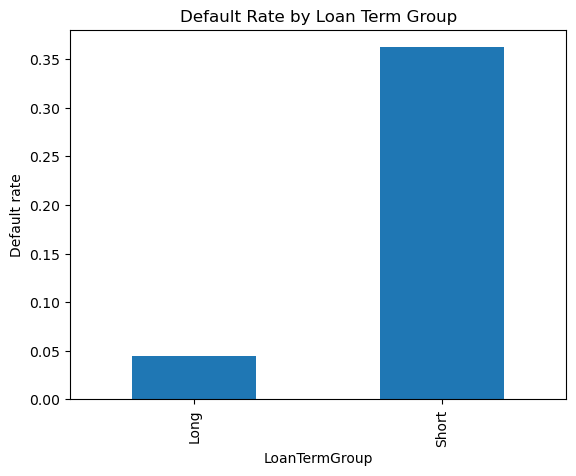

In [19]:
# Bar plot: default rate by loan term group
default_rates = df.groupby('LoanTermGroup')['Default'].mean()
default_rates.plot(kind='bar')
plt.ylabel('Default rate')
plt.title('Default Rate by Loan Term Group')
plt.savefig("figures/default_rate_by_loan_term_group.png", bbox_inches="tight")
plt.show()

The bar chart shows a clear difference in default rates between short-term and long-term loans, motivating formal hypothesis testing.

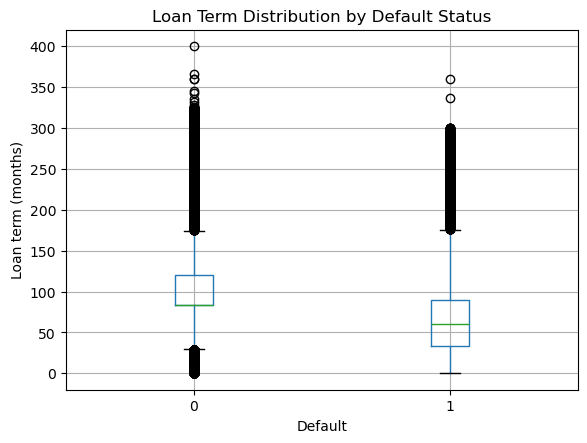

In [29]:
# Boxplot: loan term distribution by default status
df.boxplot(column='TerminMonths', by='Default')
plt.ylabel('Loan term (months)')
plt.title('Loan Term Distribution by Default Status')
plt.suptitle('')
plt.savefig("figures/loan_term_distribution_by_default.png", bbox_inches="tight")
plt.show()

In [21]:
# Calculate default rate for each loan term group
default_rates = df.groupby('LoanTermGroup')['Default'].mean()
default_rates

LoanTermGroup
Long     0.04452
Short    0.36214
Name: Default, dtype: float64

In [22]:
# Compute default rates for short-term and long-term loans, and their difference

rates = df.groupby('LoanTermGroup')['Default'].mean()
diff = rates['Long'] - rates['Short']
rates, diff

(LoanTermGroup
 Long     0.04452
 Short    0.36214
 Name: Default, dtype: float64,
 -0.3176198464178212)

In [23]:
# Permutation test: shuffle group labels to see how unusual the observed difference is
n_perm = 5000
observed = diff  # Long - Short

perm_diffs = np.empty(n_perm)

for i in range(n_perm):
    shuffled = df['LoanTermGroup'].sample(frac=1, replace=False).to_numpy()
    perm_diffs[i] = df['Default'].groupby(shuffled).mean()['Long'] - df['Default'].groupby(shuffled).mean()['Short']

p_value = (np.abs(perm_diffs) >= np.abs(observed)).mean()
observed, p_value

(-0.3176198464178212, 0.0)

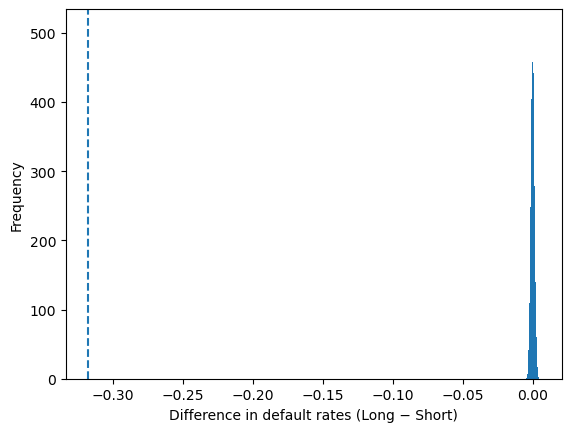

In [24]:
# Plot the permutation distribution of differences under the null hypothesis
plt.hist(perm_diffs, bins=30)
plt.axvline(observed, linestyle='--')
plt.xlabel('Difference in default rates (Long − Short)')
plt.ylabel('Frequency')
plt.savefig("figures/permutation_test_distribution.png", bbox_inches="tight")
plt.show()

Conclusion

Long-term loans (terms ≥ 60 months) make up the majority of the dataset, with a much larger number of observations compared to short-term loans (terms < 60 months).

However, short-term loans have a substantially higher default rate. The estimated default rate for long-term loans is approximately 4.5%, while the default rate for short-term loans is approximately 36.2%. The observed difference in default rates (long − short) is about −0.318, indicating that short-term loans default at a much higher rate.

A permutation test was conducted to assess whether this difference could be explained by random chance. The observed difference lies far outside the permutation distribution under the null hypothesis, and the resulting p-value is effectively 0. This provides strong statistical evidence against the null hypothesis.

Therefore, we reject the null hypothesis and conclude that short-term loans have significantly higher default rates than long-term loans in this dataset.

In [25]:
# Bootstrap 95% CI for the median loan term (TerminMonths)
term = df['TerminMonths'].dropna()
term = term[term > 0]  

B = 5000
boot_medians = np.empty(B)

for b in range(B):
    sample = term.sample(n=len(term), replace=True)
    boot_medians[b] = sample.median()

ci_low, ci_high = np.percentile(boot_medians, [2.5, 97.5])
observed_median = term.median()

observed_median, (ci_low, ci_high)

(84.0, (84.0, 84.0))

In [26]:
# Bootstrap the difference in median loan term between long-term and short-term loans

long_terms = df[df['LoanTermGroup'] == 'Long']['TerminMonths'].dropna()
short_terms = df[df['LoanTermGroup'] == 'Short']['TerminMonths'].dropna()

B = 5000
boot_diff_medians = np.empty(B)

for b in range(B):
    long_sample = long_terms.sample(n=len(long_terms), replace=True)
    short_sample = short_terms.sample(n=len(short_terms), replace=True)
    boot_diff_medians[b] = long_sample.median() - short_sample.median()

ci_low, ci_high = np.percentile(boot_diff_medians, [2.5, 97.5])
observed_diff = long_terms.median() - short_terms.median()

observed_diff, ci_low, ci_high

(54.0, 54.0, 54.0)

In [27]:
# Bootstrap a 95% confidence interval for the median loan amount,
# comparing defaulted (CHGOFF) and non-defaulted (PIF) loans

defaulted = df[df['Default'] == 1]['GrossApproval'].dropna()
non_defaulted = df[df['Default'] == 0]['GrossApproval'].dropna()

B = 5000
boot_diff = np.empty(B)

for b in range(B):
    d_sample = defaulted.sample(n=len(defaulted), replace=True)
    nd_sample = non_defaulted.sample(n=len(non_defaulted), replace=True)
    boot_diff[b] = d_sample.median() - nd_sample.median()

ci_low, ci_high = np.percentile(boot_diff, [2.5, 97.5])
observed_diff = defaulted.median() - non_defaulted.median()

observed_diff, ci_low, ci_high

(-7000.0, -10000.0, -5000.0)

Metric 2: We examine the difference in the median loan term between defaulted loans (CHGOFF) and non-defaulted loans (PIF).
The median is used because loan term distributions are discrete and skewed, and the median does not rely on the Central Limit Theorem, making bootstrap an appropriate method for uncertainty estimation.

In [28]:
# Bootstrap a 95% confidence interval for the difference in median loan term (defaulted − non-defaulted)

defaulted_term = df[df['Default'] == 1]['TerminMonths'].dropna()
non_defaulted_term = df[df['Default'] == 0]['TerminMonths'].dropna()

B = 5000
boot_term_diff = np.empty(B)

for b in range(B):
    d_sample = defaulted_term.sample(n=len(defaulted_term), replace=True)
    nd_sample = non_defaulted_term.sample(n=len(non_defaulted_term), replace=True)
    boot_term_diff[b] = d_sample.median() - nd_sample.median()

ci_low, ci_high = np.percentile(boot_term_diff, [2.5, 97.5])
observed_diff = defaulted_term.median() - non_defaulted_term.median()

observed_diff, (ci_low, ci_high)

(-24.0, (-24.0, -24.0))

Why the Central Limit Theorem Does Not Apply

In this analysis, the median is used instead of the mean. The Central Limit Theorem applies to sample means, not to medians. In addition, the distributions of loan amounts and loan terms are highly skewed and contain outliers. Because of this, the sampling distribution of the median is not guaranteed to be approximately normal, even with a large sample size. Therefore, the Central Limit Theorem cannot be used to estimate uncertainty for the median in this case.

Why Bootstrap Is Appropriate

Bootstrap resampling does not rely on assumptions about the shape of the underlying distribution. Instead, it uses repeated resampling from the observed data to approximate the sampling distribution of the statistic of interest. This makes bootstrap methods well suited for estimating uncertainty for the median and for differences in medians, especially when the Central Limit Theorem does not apply.

Interpretation of Bootstrap Results

The 95% bootstrap confidence interval for the difference in median loan term between defaulted and non-defaulted loans is [-24, -24] months. Because this interval does not include zero, it indicates a statistically meaningful difference between the two groups. Specifically, defaulted loans have a shorter median loan term than non-defaulted loans by approximately 24 months. This result is consistent with the permutation test findings and supports the hypothesis that loan term length is associated with default behavior.

Results
Exploratory Data Analysis (EDA) Summary

The dataset includes a large number of SBA 7(a) loans, which were categorized into short-term loans (less than 60 months) and long-term loans (60 months or more).
Exploratory analysis showed that long-term loans are much more common than short-term loans.
Initial comparisons indicated clear differences in default behavior between loan groups, motivating formal hypothesis testing.

Permutation Test Results

A permutation test was conducted to compare default rates between long-term and short-term loans.
The observed difference in default rates (Long − Short) was approximately −0.318, indicating that short-term loans have a higher default rate than long-term loans.
The permutation test produced a p-value of 0.0, showing that this difference is extremely unlikely to occur by random chance under the null hypothesis.
This provides strong evidence of an association between loan term length and default rates.

Bootstrap Results

Bootstrap resampling was used to estimate uncertainty for statistics where the Central Limit Theorem does not apply.

For the difference in median loan term between defaulted and non-defaulted loans, the 95% bootstrap confidence interval was [−24, −24] months.

This interval does not include zero, indicating a meaningful difference in loan term length between the two groups.

The results show that defaulted loans have a shorter median loan term than non-defaulted loans.

Overall, the bootstrap results are consistent with the permutation test findings and reinforce the conclusion that loan term length is associated with default behavior.

Limitations

This analysis relies on observational data, which means that the results show associations rather than causal relationships between loan term length and default behavior.

The definition of default is based on the available loan status categories (CHGOFF vs PIF). Other outcomes such as canceled or exempt loans were excluded, which may limit the scope of the findings.

Some loan characteristics and borrower risk factors that could influence default behavior are not included in the analysis, potentially leading to unobserved confounding.

Although the bootstrap analysis focuses on differences in median loan term, these results help explain the permutation test findings by showing how loan term length varies systematically with default status.

Conclusion

This analysis examined whether loan term length is associated with default behavior in SBA 7(a) loans. Loans were categorized into short-term (less than 60 months) and long-term (60 months or more), and default was defined using finalized loan outcomes (CHGOFF vs PIF).

Exploratory analysis showed clear differences in default rates between the two loan term groups. Short-term loans exhibited a substantially higher default rate than long-term loans. The observed difference in default rates (Long − Short) was approximately −0.318, indicating that short-term loans default at a much higher rate.

A permutation test was used to formally assess this difference. The observed statistic lay far outside the permutation distribution under the null hypothesis, resulting in a p-value effectively equal to zero. This provides strong statistical evidence against the null hypothesis of no difference in default rates between loan term groups.

Bootstrap methods were used to estimate uncertainty for statistics where the Central Limit Theorem does not apply, specifically the median loan term. The 95% bootstrap confidence interval for the difference in median loan term between defaulted and non-defaulted loans did not include zero, indicating a meaningful difference. Defaulted loans were found to have shorter median loan terms than non-defaulted loans.